 **딥러닝 기반 네트워크 트래픽 데이터 분류**
- 정상 및 공격으로 분류하기

학번 : 2019xxxxxx

이름 : 전xx

**<제출물>**

 학습 코드 및 학습된 모델 (train/...)
- 전처리 포함 학습을 직접 했다는 것을 증명할 수 있는 폴더
- 개발에 사용한 모든 파일을 포함

테스트 코드 (test/...)
- 테스트 데이터를 통해 본인이 학습한 모델을 평가할 수 있도록 구성
- 데이터 전처리, 학습모델 구조, 학습된 피라미터(.pt)파일을 포함
- 실행 오류시 채점 x

**목표 데이터 셋**
  
  네트워크 트래픽 데이터
- 네트워크 환경에서 정상적인 활동과 다양한 공격 행위를 포함한 혼합 트래픽 데이터 수집를 수집하기 위해 설계된 데이터셋

- 49개의 Feature(Feature.csv 파일참고)
- 네트워크 트래픽의 다양한 특성을 반영
- 트래픽의 정상 및 공격 유형을 분류하는 데 사용
- 총 9가지 유형의 공격 포함 - Fuzzers, Analysis, Backdoors, Dos, Exploits, Generic, Reconnaissance, Shellcode, Worms

- 학습 데이터 (배포) -> 약 17만 개의 데이터로 구성
- 테스트 데이터 (평가) -> 약 8만개의 데이터로 구성

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Now using {device}.")

Now using cuda.


 # **파일 경로 수정하는 곳 입니다**

 **반드시 train_save, scaler_save는 폴더가 있어야 합니다.**

 폴더가 없으면 자동적으로 폴더를 생성하도록 구현하지 않아서 드라이브에 업로드하거나 직접 폴더를 만들어야 합니다.  
 폴더가 없으면 실행이 안됩니다.

 데이터 셋은 ai보안 데이터폴더에 있으며, 폴더를 업로드 하시거나 경로를 수정하시면 됩니다.

 ai보안 데이터셋 : 모델을 학습하기위한 training-set.csv등 데이터셋이 있는 폴더.

 train_save : 학습한 모델(pth)을 저장한 폴더

 scaler_save : onehot_encoder.pkl, scaler.pkl 등 pkl파일을 저장하는 폴더

In [ ]:
# trian 파일 경로
filepath = '/content/drive/MyDrive/ai보안 데이터셋/training-set.csv'

# 모델 저장 경로 및 저장한 모델 이름 정의
model_path = f'/content/drive/MyDrive/train_save/cnn_model_epoch.pth'

#**학습 데이터 전처리**
<과정>
1. 데이터를 로드 및 불필요한 칼럼을 제거
2. 다중 클래스 분류를 위해 목표 타겟인 attack_cat를 인코딩
3. 결측치 제거
4. 특정 변수 및 타겟 변수 분리
5. 범주형 변수 처리를 원핫 인코더로 처리
6. 훈련중에 새로운 범주형 데이터가 있으면 무시하고 학습
7. 특정 데이터를 결합
8. 스케일링을하여 변수들간 스케일 차이를 낮춤

Q. 왜 attack_cat를 인코딩 했는가?  
A: attack_cat은 문자열로되어 있어 데이터를 처리할수 없기때문에 숫자로 변환하여 데이터를 처리해야합니다.

Q. 원핫인코더를 사용한 이유는?

A: 라벨인코딩은 범주형 정수값을 변환하는 방식인데,이러한 단점은 모든 숫자들이 수차적인 순서나 크기를 가질수 있다고 잘 못된 해석을 할 수 있기때문에, 원핫인코딩을 사용하여 각 범주를 이진벡터로 변환하고, 각각의 범주를 별개의 변수로 취급하기 때문에잘못된 순서나 크기를 학습하지 않아도 되고 새로운 범주를 무시하는 기능이 있어 새범주가 있어도 무시하고 일관성있게 훈련을 할 수 있기때문입니다.  

In [ ]:
# 학습 데이터 전처리
def train_process_data(filepath, is_training):
    data = pd.read_csv(filepath)

    # id 칼럼 제거
    if 'id' in data.columns:
        data = data.drop('id', axis=1)

    # 정상 공격인 Normal를 포함하여 attack_cat를 리스트로 매핑
    attack_categories = ['Normal', 'Fuzzers', 'Analysis', 'Backdoor', 'DoS', 'Exploits',
                         'Generic', 'Reconnaissance', 'Shellcode', 'Worms']
    attack_cat_map = {category: idx for idx, category in enumerate(attack_categories)}

    # attack_cat를 정수로 매핑
    data['attack_cat'] = data['attack_cat'].map(attack_cat_map)

    # 학습을 위해 features와 labels를 분리
    if is_training:
        y = data['attack_cat'].values  # 매핑된 공격 유형을 라벨로 사용.
        X = data.drop(['attack_cat', 'label'], axis=1)   # attack_cat과 Label을 피처에서 제거
    else:
        X = data.drop(['attack_cat', 'label'], axis=1)

    # 범주형 변수들에 원핫 인코딩을 정의
    categorical_cols = ['proto', 'service', 'state']

    # 원핫 인코딩
    onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_cat = onehot_encoder.fit_transform(X[categorical_cols])

    # 테스트 과정에서 일관된 전처리를 사용하기 위해 원핫 인코딩 저장
    joblib.dump(onehot_encoder, '/content/drive/MyDrive/scaler_save/onehot_encoder.pkl')

    # 원래 범주형 칼럼을 제거 및 원한 인코딩 칼럼을 추가
    X = X.drop(columns=categorical_cols)
    X = np.concatenate([X.values, X_cat], axis=1)

    # features을 스케일링 후 테스트 코드에서 사용하기 위해 저장
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    joblib.dump(scaler, '/content/drive/MyDrive/scaler_save/scaler.pkl')

    # X의 타입이 float32로 되도록 바꿈
    X = X.astype(np.float32)

    if is_training:
        return X, y, onehot_encoder, scaler
    else:
        return X, onehot_encoder, scaler


# Train 및 Validate

훈련 및 검증을 하는 함수를 구현.

In [ ]:
# 훈련 함수
def train(device, model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# 검증 함수
def validate(device, model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(y).sum().item()
    accuracy = correct / len(test_loader.dataset)
    return total_loss / len(test_loader), accuracy

def accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# 데이터 준비

데이터 로드, 데이터 분할, 데이터셋을 준비하고,

모델에 배치 크기에 맞게 입력할 수록 준비합니다.


In [ ]:
# 데이터 트레이닝 셋 로드
#filepath = '/content/drive/MyDrive/ai보안 데이터셋/training-set.csv'

# 데이터 로드
X_train, y_train, label_encoders, scaler =  train_process_data(filepath, is_training=True)

# 학습 및 검증 데이터 8대2로 분할
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# TensorDataset 및 DataLoader 생성
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #배치크기 64, 128 등 알맞게 설정.
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



# 모델 정의

CNN를 선택했습니다.

이유 : 전처리 과정이 중요하고, 어떤 모델을 사용하든

전처리를 제대로 하지 않으면 성능이 잘 안나오기 때문에

전처리를 잘 했다면, 준수한 성능이 나오고, CNN의 지역적인 특성을 학습하는데

뛰어나 네트워크 트래픽 분류라는 시계열 데이터에서 일정한 패턴을 찾아내는 것에

적합하다고 판단 하였고 CNN의 특성한 레이어를 추가하거나 삭제하는듯 조정하는것이

쉬워 모델 확장에도 용이하기 때문에 선택하였습니다

In [ ]:
# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN, self).__init__()

        # Conv1D 층
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, padding=1)

        # 풀링 층
        self.pool = nn.MaxPool1d(2)

        #  완전 연결 층
        self.fc1 = nn.Linear(256 * (input_size // 16), 512)  # input_size // 16은 4개의 풀링 레이어에서 줄어든 크기
        self.fc2 = nn.Linear(512, 256)

        # 출력층
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Conv1D 입력을 위한 채널 추가
        x = x.unsqueeze(1)

        # Conv1D + ReLU + 풀링
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        # Flatten (배치 크기 및 특징을 펼침)
        x = x.view(x.size(0), -1)

        # 완전 연결층 + ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # 출력층
        x = self.fc3(x)
        return x

# 모델 설정

모델에 훈련 데이터의 특성 수의 입력 크기와 타겟의 클래스 수를 확인하고 모델에 입력

손실함수는 다중 클래스 분류 문제에서 사용하는 CrossEntropyLoss설정하여  모델예측과 실제레이블 간의 차이를 계산 후 손실을 반환

최적화는 아담 옵티마이저를 사용했고, 자동으로 학슬율이 조정됩니다
초기값은 1e-4로 설정했습니다.


In [ ]:
print("입력 크기 확인 : ", X_train.shape[1])
print("클래스 분류 값 확인 : ", len(np.unique(y_train)))

# 모델, 손실 함수, 옵티마이저 설정
model = CNN(input_size=X_train.shape[1], num_classes=len(np.unique(y_train))).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 손실 및 정확도 저장을 위한 리스트
train_losses = []
test_accuracies = []


입력 크기 확인 :  194
클래스 분류 값 확인 :  10


#모델 학습

모델을 학습하고 학습한 모델을 저장합니다

In [ ]:
# 학습 루프
epochs = 10
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
for epoch in range(epochs):
    train_loss = train(device, model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(device, model, val_loader, criterion)
    scheduler.step()
    train_losses.append(train_loss)
    test_accuracies.append(val_acc)
    # 에폭, 훈련 손실, 검증 손실, 검증 정확도 출력
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%')

# 모델 저장
# model_path = f'/content/drive/MyDrive/train_save/cnn_model_epoch.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')


Epoch 1/10, Train Loss: 0.6805, Val Loss: 0.5691, Val Acc: 78.07%
Epoch 2/10, Train Loss: 0.5530, Val Loss: 0.5336, Val Acc: 79.04%
Epoch 3/10, Train Loss: 0.5278, Val Loss: 0.5246, Val Acc: 78.99%
Epoch 4/10, Train Loss: 0.5117, Val Loss: 0.5054, Val Acc: 80.19%
Epoch 5/10, Train Loss: 0.5008, Val Loss: 0.5053, Val Acc: 80.01%
Epoch 6/10, Train Loss: 0.4919, Val Loss: 0.4925, Val Acc: 80.60%
Epoch 7/10, Train Loss: 0.4850, Val Loss: 0.4910, Val Acc: 80.46%
Epoch 8/10, Train Loss: 0.4795, Val Loss: 0.4832, Val Acc: 80.89%
Epoch 9/10, Train Loss: 0.4756, Val Loss: 0.4818, Val Acc: 80.91%
Epoch 10/10, Train Loss: 0.4733, Val Loss: 0.4808, Val Acc: 81.00%
Model saved to /content/drive/MyDrive/train_save/cnn_model_epoch.pth


#**Visualization**

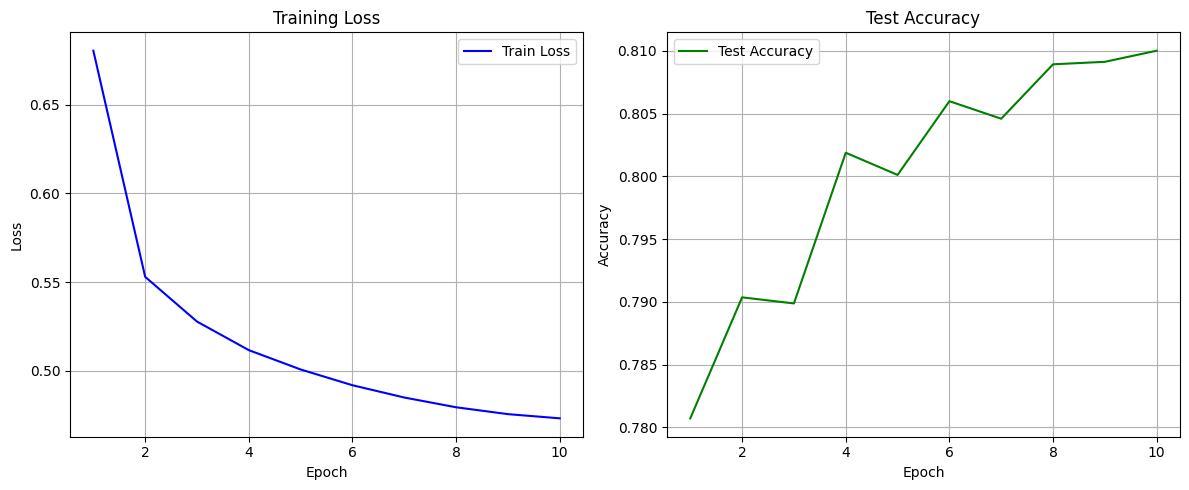

In [ ]:
# 손실과 정확도 시각화
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', color='green')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()